<a href="https://colab.research.google.com/github/smlra-kjsce/DL-in-NLP-101/blob/master/ULMFiT%20for%20Review%20Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ULMFiT Notebook

##Preparing Dataset

In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nik9hil","key":"72915fdbdc01530a0423ad344f93e74e"}'}

In [0]:
!mkdir ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews -p /content

 97% 25.0M/25.7M [00:01<00:00, 19.5MB/s]
100% 25.7M/25.7M [00:01<00:00, 24.1MB/s]


In [0]:
!unzip imdb-dataset-of-50k-movie-reviews.zip

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [0]:
import pandas as pd

df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
trn_texts = df.loc[10000:14999, 'review'].values
trn_labels = df.loc[10000:14999, 'sentiment'].values
val_texts = df.loc[36000:38999, 'review'].values
val_labels = df.loc[36000:38999, 'sentiment'].values

In [0]:
import numpy as np

np.random.seed(66)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [0]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

col_names = ['labels','text']
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

##Fast.AI Implementation 

In [0]:
from fastai import *
from fastai.text import *

data_lm = TextLMDataBunch.from_df('./', train_df=df_trn, valid_df=df_val)

In [0]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'a',
 'and',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

In [0]:
data_lm.show_batch()

idx,text
0,"xxmaj first , xxmaj cole xxmaj wilkison ( xxmaj brian xxmaj keith ) comes back from xxmaj texas to help his brother run xxmaj anchor xxmaj then a tough kid with a fancy gun ( xxmaj richard xxmaj jaeckel ) shows up on the xxmaj wilkison payroll xxmaj then all the small ranchers are forced out , getting the same kind of offers xxmaj"
1,xxmaj it 's just a throwaway role that takes up all of 20 minutes in the 100 minute film . xxmaj god just pops up in between scenes to tell xxmaj evan to build the ark . xxmaj sure i know xxmaj morgan xxmaj freeman wo n't look at this film in a year and think it 's as good as his roles in xxmaj the xxmaj shawshank xxmaj redemption
2,"xxmaj encino man from xxmaj lambert 's xxmaj tarzan . xxmaj it was stiff , and while his xxmaj tarzan call was a little more realistic , he had no humanity . 2 . xxmaj they screwed with the story . xxmaj maybe that 's how the book goes , but for as long as i can remember the first utterances of xxmaj tarzan were "" xxmaj me tarzan ,"
3,", decided to take xxmaj the xxmaj monkees in this unusual direction . xxmaj it 's as if xxmaj new xxmaj kids on the xxmaj block suddenly put out an album equivalent to xxmaj pink xxmaj floyd 's xxmaj xxunk ( 1969 ) or xxmaj atom xxmaj heart xxmaj mother ( 1970 ) . xxmaj in fact , the songs in xxmaj head , written by xxmaj the xxmaj monkees"
4,"for you ( not that there are subtitles , there 's no dialog at all ) . xxmaj if you 're someone that actually owns xxmaj rush xxmaj hour 2 then this movie is n't for you . \n \n xxmaj this movie is truly original and inspiring . xxmaj it does what other movies have never done . xxmaj it looks like nothing else and is xxunk than"


In [0]:
data_lm.train_ds[0][0].data[:10]  #verification

array([   2,   22,    5,    9,    5, 1159,    5,  371,   22, 5026])

In [0]:
#import os
#os.chdir('./drive/My Drive/Colab Notebooks/')

#data_lm.save('tmp_lm')


#data_lm = TextClasDataBunch.load('./', 'tmp_lm')

In [0]:
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [0]:
learner.lr_find()   #stop_div and num_it

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


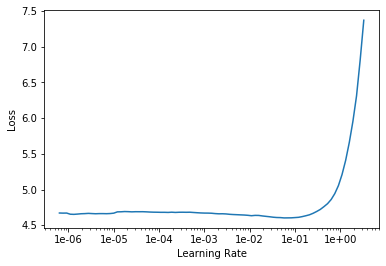

In [0]:
learner.recorder.plot()

In [0]:
learner.unfreeze()
learner.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.215938,3.984792,0.294971,03:48


In [0]:
learner.predict("This is a review about", n_words=10)

'This is a review about life talent , vessels of decades after intriguing experiences .'

In [0]:
learner.save_encoder('fine_enc')

In [0]:
data_clas = TextClasDataBunch.from_df('./', train_df=df_trn, valid_df=df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
classifier = text_classifier_learner(data_clas, AWD_LSTM,drop_mult=0.5)
classifier.load_encoder('fine_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5000 items)
x: TextList
xxbos " xxmaj the xxmaj violent xxmaj men " marked the finest collaboration of xxmaj rudolph xxmaj xxunk with xxmaj glenn xxmaj ford in an intensely satisfying drama of rugged primitive justice 
 
 
  xxmaj ford is xxmaj john xxmaj parrish , a former xxmaj cavalry captain who is xxunk to get married and start a new life 
  xxmaj his fiancée xxmaj caroline xxmaj xxunk ( xxmaj may xxmaj wynn ) is desperate to move east , and to see him selling his spread to xxmaj lee xxmaj wilkison ( xxmaj edward xxup g. xxmaj robinson ) . 
 
  xxmaj parrish is not even much of a xxunk 
  but he do understand that there is something big building up in the valley 
  xxmaj in the xxmaj army , they used to call it ' enemy pressure . ' xxmaj first , xxmaj cole xxmaj wilkison ( xxmaj brian xxmaj keith ) comes back from xxmaj texas to help his brother run xxmaj anchor 
  xxmaj then a tough kid with a fancy gun ( xxmaj richard xxmaj j

In [0]:
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


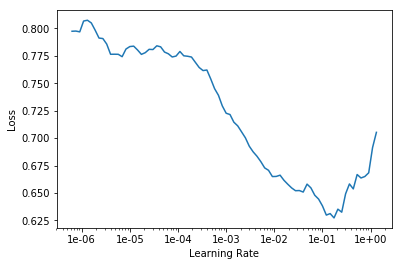

In [0]:
classifier.recorder.plot()

In [0]:
classifier.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.454478,0.355064,0.852000,02:24


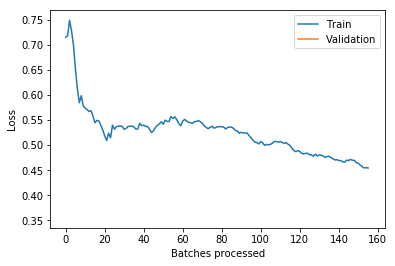

In [0]:
classifier.recorder.plot_losses()

In [0]:
classifier.save("trained_model", return_path=True)

PosixPath('models/trained_model.pth')

In [0]:
classifier.export("trained-model.pkl")

In [0]:
classifier.predict("The Google Pixel 4 has an excellent battery life, It also has a large screen that is notch less and gives user an amazing experience!")

(Category positive, tensor(1), tensor([0.0063, 0.9937]))

In [0]:
reloaded=load_learner("./models","trained-model.pkl")

In [0]:
reloaded.predict("The Google Pixel 4 has an excellent battery life, It also has a large screen that is notch less and gives user an amazing experience!")

(Category positive, tensor(1), tensor([0.0063, 0.9937]))

In [0]:
#!pip install youtube_transcript_api
#!pip install textblob
!python -m textblob.download_corpora

#reloaded.predict("")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [0]:
from youtube_transcript_api import YouTubeTranscriptApi
from textblob import TextBlob

transc_dict = YouTubeTranscriptApi.get_transcript('RQhRX8roCWc')
text = str()

for i in range(len(transc_dict)):
    #print(i)
    if i==0:
        text+=transc_dict[i]['text']
    elif i%5==0:
        text+='. '+transc_dict[i]['text']
    else:
        text+=' '+transc_dict[i]['text']
print(text)

blob = TextBlob(text)
print(len(blob.sentences))

I don't typically make videos about products that are straight up don't recommend buying but I'm afraid this will be one of those so let's talk about puffin OS so I have two identical red. MIGO smartphones here one in its original form with Android go which is a pretty typical Xiaomi phone that was built for developing markets and one with this very bizarre new operating. system called puffin OS that is currently in a kick starter face the company sent me these two phones to test how puffin OS performs against comparable cheap Android go phones as. well as against smart feature phones like iOS so I've teamed up with Aaron from the mister who's the boss channel and we will do just that I will do a deep dive on puffin OS in this video. Aaron will analyze Kai OS in his and then once you finish watching both there will be a link in the description below that will lead you to a poll so you can decide which one you like the most. maybe puffin OS maybe Kos or maybe just good old Android go pu

In [0]:
reloaded.predict(text)

(Category negative, tensor(0), tensor([0.9142, 0.0858]))